# STEM Optimization Analysis

This notebook demonstrates the basic functionality of the intensity analysis by using the optimization method 

Third-Party Python packages required:

Package "tifffile" for opening the experimental target image

Package "ASE" for importing the initial model


In [1]:
%matplotlib notebook
import os,sys
sys.path.append('/home/christoph/repos/stem_optimization/')
from Model import Model
from Simulation import Simulation
from ase.io import read, write
import matplotlib.pyplot as plt
from tifffile import tifffile
import numpy as np
#import time
import threading
import pickle
from ase.visualize import view
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from ase import Atoms

We start by loading the target image, which has to be an atomically resolved STEM-ADF image and initializing important parameters for the simulation.

We also start a new thread to plot and update the target image, the simulation, the difference, the PSF and the correlation.


<IPython.core.display.Javascript object>


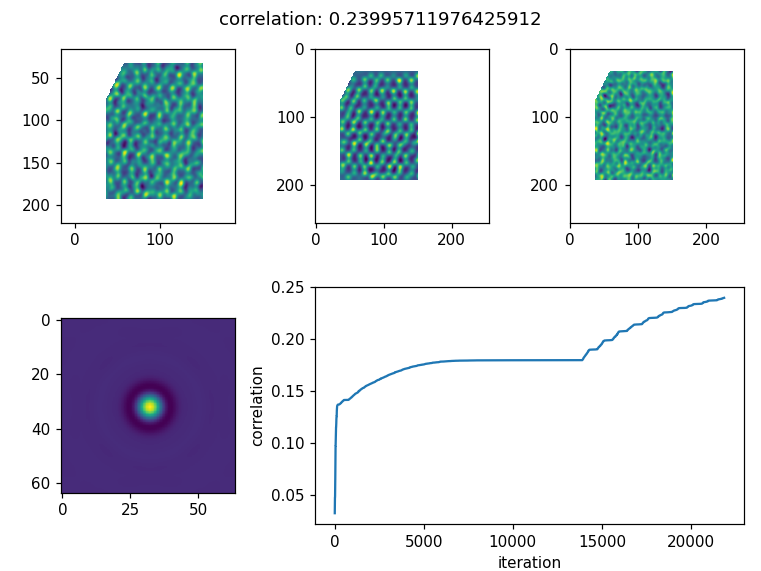

In [14]:
path = '.'
os.chdir(path)
image = tifffile.imread('ws26-small.tif').T
image = tifffile.imread('ws26-masked2.tif').T
#image[:,148:]=np.nan
model = read('ws2_30.xyz')
reset = True # False if specific pickle file is used
## The size of the kernel which is used for image convolution is chosen to be 
# "1/kernelsize" of the image size (in pixels)#


#model = orthogonalize_cell( mx2(formula='WS2'))
#model = model[model.positions[:,2]<3]
#model*=(10,5,1)
#model.positions[:,2] = 0

model.rotate('y',-5)


#model.set_cell([fov,fov,4])

conv_angle = 0.03 #rad
energy = 60000 #eV
fov = 4.35#nm
#fov = 2.5#nm
pixel0  =  [40,35]
#pixel0  =  [9,2]

atom0 =  0

px = np.max(image.shape)

scale = px/fov/10

at_cp = []
'''
for at in model:
    #print(at.position*scale)
    if (at.position[0]*scale<0 or at.position[0]*scale>px or  
        at.position[1]*scale<0 or at.position[1]*scale>px):
            #print(str(at.index)+' outside of image')
            del at
    elif np.isnan(image[int(at.position[1]*scale+0.5),int(at.position[0]*scale+0.5)]):
            #print(str(at.index)+' in mask of image')
            continue
    else:
        at_cp.append(at)
atoms = Atoms(at_cp) 
atoms = atoms[atoms.positions[:,2]<3]
atoms.positions[:,2] = 0
'''
#atoms.rotate(20,'y')
m = Model(model,image, kernelsize=4, start_PlotThread=True,contrast = 0.0)


blur = px/(fov*10)*0## 0.3 A source size
m.set_up_simulation(conv_angle, energy, fov ,atom0=atom0,pixel0=pixel0, blur=blur,method='SSB' )

plot_thread = threading.Thread(target = m.plotting_thread,args = (m.fig,m.ax), daemon=True)
plot_thread.start()
    


We now run the optimization, while the plot above constantely updates

Possible parameters: aberrations, blur, positions, fov, intensities

In [27]:
#starttime = time.time()

rounds=30
#m.optimize_model(['tilt'],iterations = rounds)
m.optimize_model(['fov','blur','translation','scale'],iterations = rounds)
m.optimize_model(['fov','blur','intensities'],iterations = rounds)
rounds = 10
#m.optimize_model(['aberrations','blur','intensities'],iterations = rounds)
m.optimize_model(['intensities','positions'],iterations = rounds)
#rounds = 40

#print('method finished after '+str((time.time()-starttime)/rounds)+' seconds per iteration' )
write('model_optimized.xyz',m.ase)
np.save('model.parameters',m.get_parameters(),allow_pickle=True)


100%|██████████| 10/10 [05:25<00:00, 32.53s/it]


To save the object, pickle is used 

In [28]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(m, path+'model_init.pkl')

## this code can load the pickle object again
'''
with open(path+'model_new.pkl', 'rb') as pickle_file:
    m = pickle.loadäß´2qqaysyxcfcvgbhnjm,.ö-ä'pickle_file)
'''

"\nwith open(path+'model_new.pkl', 'rb') as pickle_file:\n    m = pickle.loadäß´2qqaysyxcfcvgbhnjm,.ö-ä'pickle_file)\n"

We can now analyze the atomic intensities.

<IPython.core.display.Javascript object>


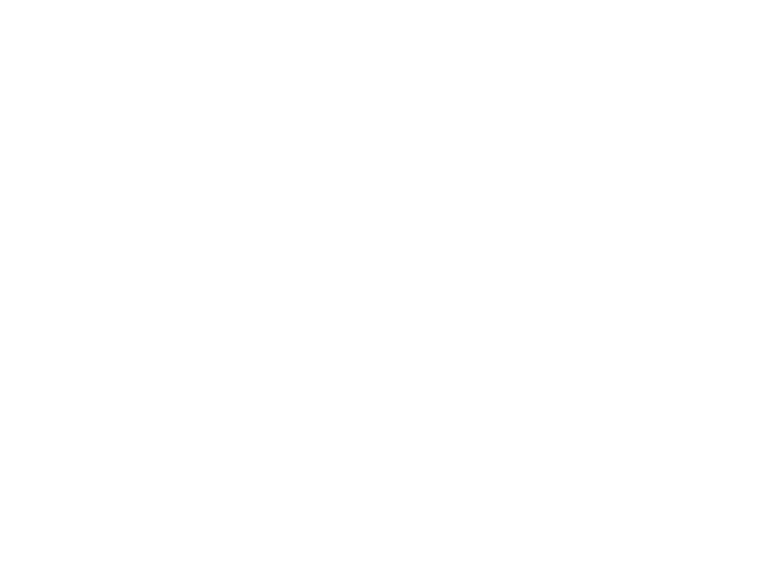

IndexError: boolean index did not match indexed array along dimension 0; dimension is 117 but corresponding boolean dimension is 210

In [29]:
plt.figure()
plt.hist([m.get_relative_intensities()[m.ase.numbers == 74],m.get_relative_intensities()[m.ase.numbers == 16]],25)
plt.xlabel('relative intensities')
plt.ylabel('counts')
plt.show()

In [ ]:
from abtem.visualize import show_atoms
at = m.ase
sel = (at.get_positions()[:,1]>4)*(at.get_positions()[:,1]<20)*(at.get_positions()[:,0]>4)*(at.get_positions()[:,0]<20)
ws = at[(at.numbers==74)*sel]
s = at[(at.numbers==16)*sel]


In [ ]:
pxpos = m.sim.unit_conversion()
ints_w = m.intensities[(at.numbers==74)*sel]#/np.mean(m.intensities[sel])
ints_s = m.intensities[(at.numbers==16)*sel]#/np.mean(m.intensities[sel])



In [ ]:
plt.figure()
plt.hist([ints_w,ints_s])
plt.show()

In [ ]:
(np.mean(ints_s)*2/np.mean(ints_w))

In [24]:
(np.std(ints_w)/np.mean(ints_w)/np.sqrt(len(ints_w))
 +np.std(ints_s)/np.mean(ints_s)/np.sqrt(len(ints_s)))*np.mean(ints_w)/np.mean(ints_s)

0.26227718935826677

In [66]:
m.rotation

[-1.7483352254417408, 0.07891533193504804]

In [57]:
view(m.ase)

In [58]:
from abtem.visualize import show_atoms

<IPython.core.display.Javascript object>


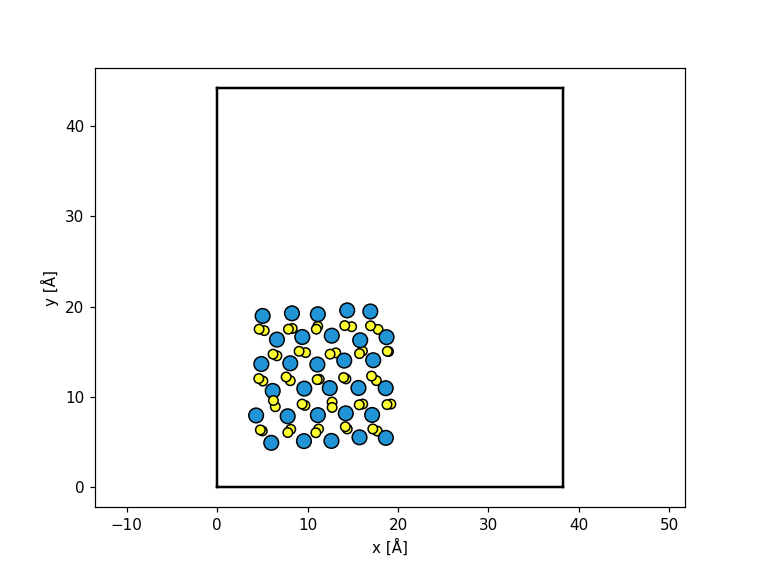

<IPython.core.display.Javascript object>


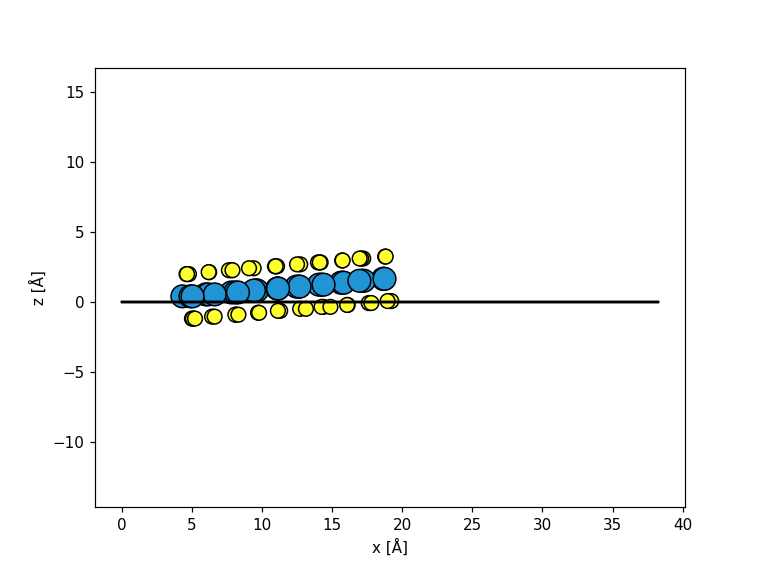

<AxesSubplot:xlabel='x [Å]', ylabel='z [Å]'>

In [25]:
show_atoms(model[sel])
show_atoms(model[sel],plane = 'xz')